## MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
type(y)

numpy.ndarray

In [5]:

y.shape

(70000,)

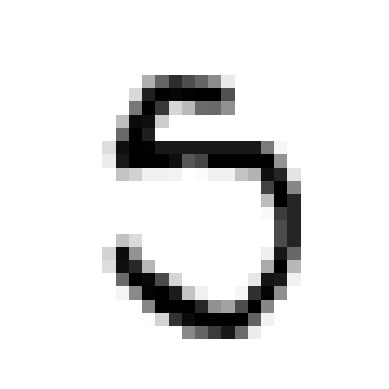

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

some_digit = X[np.random.randint(0,69999)]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
y = y.astype(np.uint8)

Training set is already shuffled

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classification

Classifier for a single digit

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=23)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=23)

In [11]:
sgd_clf.predict([some_digit])


array([ True])

## Manually implementing Cross-Validation

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.9682
0.96625
0.94645


## Using cross_val_score

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96755, 0.96715, 0.96655])

Estimating accuracy with classifier that nevers predicts 5

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

[[tru_neg, false_pos],
[true_pos, false_neg]]

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53895,   684],
       [ 1291,  4130]], dtype=int64)

precision = TP/(TP+FP), recall(sensitivity/true positive rate) = TP/(TP+FN)

In [18]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.857914416285833
0.7618520568160856


F1 score = 2/((1/precision) + (1/recall))

In [19]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.8070346849047386


In [20]:
y_score = sgd_clf.decision_function([some_digit])
y_score

array([3560.15382004])

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [22]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [23]:
precisions[:-1]

array([0.09047818, 0.090463  , 0.09046451, ..., 1.        , 1.        ,
       1.        ])

In [24]:
recalls.shape

(59916,)

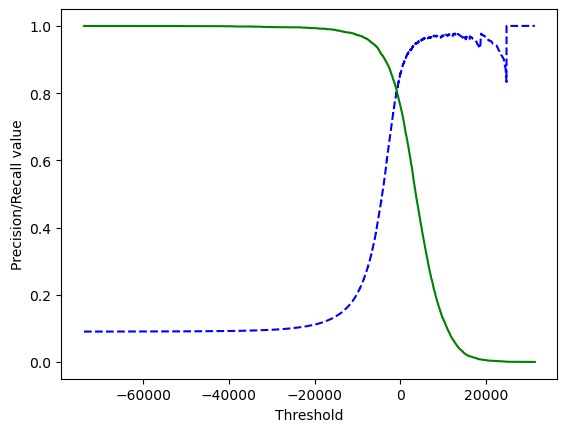

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall value')
    plt.legend(loc='left')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

## ROC Curve

Plots the true positive rate versus the false positive rate

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

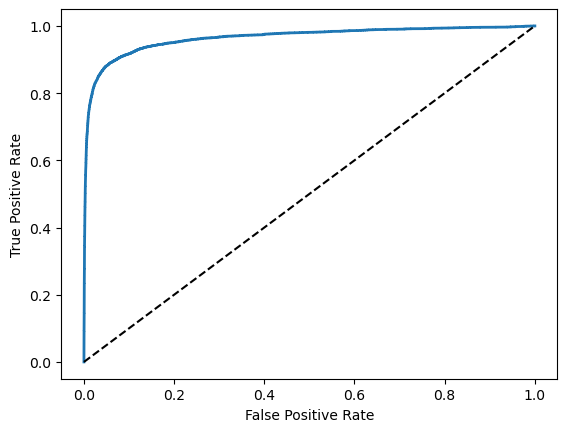

In [30]:
plot_roc_curve(fpr, tpr)
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9644818095605753

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=32)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [35]:
y_scores_forest = y_probas_forest[:,1] #score = probability of postive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

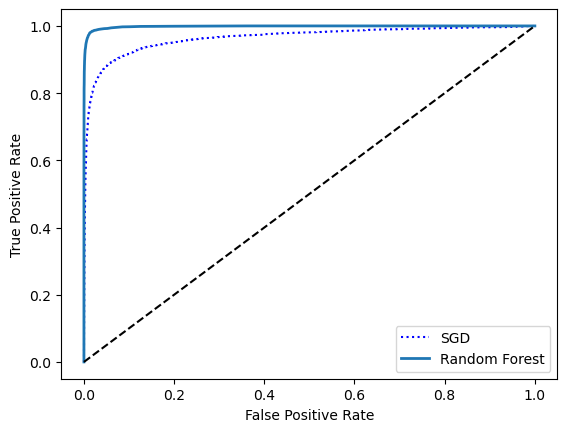

In [38]:
plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983814664059696